In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import os
import random
from torch.autograd import Variable

randomSeed = random.randint(1, 10000)
print("seed: " + str(randomSeed))
random.seed(randomSeed)
torch.manual_seed(randomSeed)

seed: 2729


In [2]:
# Initialize hyperparameters
epochs=1
max_iters=8000
batch_size=8
lr=0.0002
beta=0.5
wtl2 = 0.999
image_size = 128
workers = 4
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

In [3]:
# initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd /content/drive/Shareddrives/CIS519-GANsProject/data

/content/drive/Shareddrives/CIS519-GANsProject/data


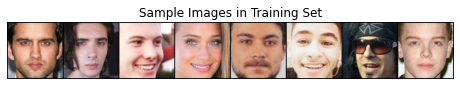

In [20]:
# may need to run this cell multiple times; Colab has a chance to time out
dataroot = "/content/drive/Shareddrives/CIS519-GANsProject/data/celeb_id_aligned_current"

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = dset.ImageFolder(root=dataroot, transform=transform )

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# GPU doesn't work on Colab with this cell
device = torch.device("cpu")

# sample images in dataloader
sample_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.title("Sample Images in Training Set")
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(sample_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [7]:
class generator(nn.Module):

    #generator model
    def __init__(self):
        super(generator,self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(4,4), stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Conv2d(512, 6400, kernel_size=(4,4)),
            nn.BatchNorm2d(6400),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=6400, out_channels=1024, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=(4,4), stride=2, padding=1),
            nn.Tanh()
            )

    def forward(self,x):
        return self.main(x)

In [8]:
#netG = generator()
#netG.apply(weights_init)

# show generator structure
#print(netG)

In [19]:
class discriminator(nn.Module):

    #discriminator model
    def __init__(self):
        super(discriminator,self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(4,4), stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=(4,4), stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        return self.main(x)

In [10]:
#netD = discriminator()
#netD.apply(weights_init)

# show discriminator structure
#print(netD)

In [ ]:
# training
load_model = True

G_loss = []
D_loss = []

PATH_D = "/content/drive/Shareddrives/CIS519-GANsProject/data/Pytorch_results/model/D_state_dict.pt"
PATH_G = "/content/drive/Shareddrives/CIS519-GANsProject/data/Pytorch_results/model/G_state_dict.pt"

netG = generator()
netD = discriminator()

if load_model:
    netG.load_state_dict(torch.load(PATH_G))
    netD.load_state_dict(torch.load(PATH_D))
else:
    netG.apply(weights_init)
    netD.apply(weights_init)

criterion = nn.BCELoss()
criterionMSE = nn.MSELoss()

label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

real = torch.FloatTensor(batch_size, 3, 128, 128)
masked = torch.FloatTensor(batch_size, 3, 128, 128)
real_center = torch.FloatTensor(batch_size, 3, 64, 64)

real = Variable(real)
masked = Variable(masked)
label = Variable(label)
real_center = Variable(real_center)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta, wtl2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta, wtl2))

for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        if i >= max_iters:
            break

        real_data = data[0].to(device)
        real_center_data = real_data[:,:,32:96,32:96]
        with torch.no_grad():
            real.resize_(real_data.size()).copy_(real_data)
            masked.resize_(real_data.size()).copy_(real_data)
            real_center.resize_(real_center_data.size()).copy_(real_center_data)
            masked[:,0,32:96,32:96] = 2 * 117.0 / 255.0 - 1.0
            masked[:,1,32:96,32:96] = 2 * 104.0 / 255.0 - 1.0
            masked[:,2,32:96,32:96] = 2 * 123.0 / 255.0 - 1.0
            label.resize_(batch_size).fill_(real_label)
        netD.zero_grad()
        output = netD(real_center).squeeze()
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.data.mean()

        # train discriminator model with fake image
        fake = netG(masked)
        label.data.fill_(fake_label)
        output = netD(fake.detach()).squeeze()
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        # train generator
        netG.zero_grad()
        label.data.fill_(real_label)
        output = netD(fake).squeeze()
        errG_D = criterion(output, label)

        wtl2Matrix = real_center.clone()
        wtl2Matrix.data.fill_(wtl2 * 10)
        wtl2Matrix.data[:, :, 4:60, 4:60] = wtl2

        errG_l2 = (fake - real_center).pow(2)
        errG_l2 = errG_l2 * wtl2Matrix
        errG_l2 = errG_l2.mean()
        errG = (1 - wtl2) * errG_D + wtl2 * errG_l2
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        G_loss.append(errG_D.item())
        D_loss.append(errD.item())

        if i % 100 == 0:

            print('[%d / %d][%d / %d] Loss_D: %.4f Loss_G: %.4f / %.4f l_D(x): %.4f l_D(G(z)): %.4f'
                % (epoch, epochs, i, max_iters, errD.data, errG_D.data, errG_l2.data, D_x, D_G_z1))

            # Save models
            torch.save(netD.state_dict(), PATH_D)
            torch.save(netG.state_dict(), PATH_G)

            try:
              os.makedirs('Pytorch_results/output')
            except OSError:
              pass

            out_fake = masked.clone()
            out_fake.data[:, :, 32:96, 32:96] = fake.data
            out_real = real_data * std[:, None, None] + mean[:, None, None]
            out_fake = out_fake.data * std[:, None, None] + mean[:, None, None]
            out_masked = masked.data * std[:, None, None] + mean[:, None, None]
            out_masked[:,:,32:96,32:96] = 255
            composite = torch.cat((out_real, out_fake, out_masked), 0)
            vutils.save_image(composite, '/content/drive/Shareddrives/CIS519-GANsProject/data/Pytorch_results/output/6400_results_epoch_%01d_iteration_%03d.png' % (epoch, i))

[0 / 1][0 / 8000] Loss_D: 1.5258 Loss_G: 10.6865 / 0.1309 l_D(x): 0.3026 l_D(G(z)): 0.0000
[0 / 1][100 / 8000] Loss_D: 0.0182 Loss_G: 4.7811 / 0.0994 l_D(x): 0.9977 l_D(G(z)): 0.0157
[0 / 1][200 / 8000] Loss_D: 0.0134 Loss_G: 5.0227 / 0.1211 l_D(x): 0.9975 l_D(G(z)): 0.0108
[0 / 1][300 / 8000] Loss_D: 0.0029 Loss_G: 6.8834 / 0.1234 l_D(x): 0.9985 l_D(G(z)): 0.0014
[0 / 1][400 / 8000] Loss_D: 0.0008 Loss_G: 7.7969 / 0.1301 l_D(x): 0.9999 l_D(G(z)): 0.0008
[0 / 1][500 / 8000] Loss_D: 0.0042 Loss_G: 6.3784 / 0.1128 l_D(x): 0.9985 l_D(G(z)): 0.0027
[0 / 1][600 / 8000] Loss_D: 0.6573 Loss_G: 7.0571 / 0.0805 l_D(x): 0.5741 l_D(G(z)): 0.0001
[0 / 1][700 / 8000] Loss_D: 1.6758 Loss_G: 0.2366 / 0.0785 l_D(x): 0.2222 l_D(G(z)): 0.0220


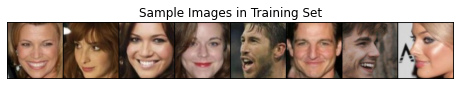

In [17]:
# test trained models on baseline images
dataroot = "/content/drive/Shareddrives/CIS519-GANsProject/data/Pytorch_results/testing_images"

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = dset.ImageFolder(root=dataroot, transform=transform )

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# GPU doesn't work on Colab with this cell
device = torch.device("cpu")

# sample images in dataloader
sample_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.title("Sample Images in Training Set")
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(sample_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [18]:
# generate baseline images output with loaded models
PATH_D = "/content/drive/Shareddrives/CIS519-GANsProject/data/Pytorch_results/model/test_D_state_dict.pt"
PATH_G = "/content/drive/Shareddrives/CIS519-GANsProject/data/Pytorch_results/model/test_G_state_dict.pt"

netG = generator()
netD = discriminator()

netG.load_state_dict(torch.load(PATH_G))
netD.load_state_dict(torch.load(PATH_D))

criterion = nn.BCELoss()
criterionMSE = nn.MSELoss()

label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

real = torch.FloatTensor(batch_size, 3, 128, 128)
masked = torch.FloatTensor(batch_size, 3, 128, 128)
real_center = torch.FloatTensor(batch_size, 3, 64, 64)

real = Variable(real)
masked = Variable(masked)
label = Variable(label)
real_center = Variable(real_center)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta, wtl2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta, wtl2))

data = next(iter(dataloader))
real_data = data[0].to(device)

for i in range(1):

  real_center_data = real_data[:,:,32:96,32:96]
  with torch.no_grad():
      real.resize_(real_data.size()).copy_(real_data)
      masked.resize_(real_data.size()).copy_(real_data)
      real_center.resize_(real_center_data.size()).copy_(real_center_data)
      masked[:,0,32:96,32:96] = 2 * 117.0 / 255.0 - 1.0
      masked[:,1,32:96,32:96] = 2 * 104.0 / 255.0 - 1.0
      masked[:,2,32:96,32:96] = 2 * 123.0 / 255.0 - 1.0
      label.resize_(batch_size).fill_(real_label)
  netD.zero_grad()
  output = netD(real_center).squeeze()
  errD_real = criterion(output, label)
  errD_real.backward()
  D_x = output.data.mean()

  # train discriminator model with fake image
  fake = netG(masked)
  label.data.fill_(fake_label)
  output = netD(fake.detach()).squeeze()
  errD_fake = criterion(output, label)
  errD_fake.backward()
  D_G_z1 = output.data.mean()
  errD = errD_real + errD_fake
  optimizerD.step()

  # train generator
  netG.zero_grad()
  label.data.fill_(real_label)
  output = netD(fake).squeeze()
  errG_D = criterion(output, label)

  wtl2Matrix = real_center.clone()
  wtl2Matrix.data.fill_(wtl2 * 10)
  wtl2Matrix.data[:, :, 4:60, 4:60] = wtl2

  errG_l2 = (fake - real_center).pow(2)
  errG_l2 = errG_l2 * wtl2Matrix
  errG_l2 = errG_l2.mean()
  errG = (1 - wtl2) * errG_D + wtl2 * errG_l2
  errG.backward()
  D_G_z2 = output.data.mean()
  optimizerG.step()

  try:
    os.makedirs('Pytorch_results/output')
  except OSError:
    pass

  out_fake = masked.clone()
  out_fake.data[:, :, 32:96, 32:96] = fake.data
  out_real = real_data * std[:, None, None] + mean[:, None, None]
  out_fake = out_fake.data * std[:, None, None] + mean[:, None, None]
  out_masked = masked.data * std[:, None, None] + mean[:, None, None]
  out_masked[:,:,32:96,32:96] = 255
  composite = torch.cat((out_real, out_fake, out_masked), 0)
  vutils.save_image(composite, '/content/drive/Shareddrives/CIS519-GANsProject/data/Pytorch_results/output/test_image.png')

In [ ]:
# plot saved losses
plt.figure(figsize=(12, 6))
plt.plot(G_loss, label="G_loss")
plt.plot(D_loss, label="D_loss")
plt.title("Generator Loss and Discriminator Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()